# Chapter 4: Deep Learning


Part 1  - Data preprocessing
------------


The objective of this first part is to learn about simple data curation practices. Data curation (for machine learning) consists basically in analyse, label, and separate in classes your input data.  In section two, you used pre-curated and separated data from the INRIA's person data set. Your first task is to create your training/testing sets by hand and analyse how well "balance" they are. 

**Objectives** 
In the following sections, you will use this part to "feed" both, a classic _Swallow_ (not-Deep) classificator using handcrafted features and a Deep (kind of Deep) neural network. Your task will consist in analyse the accuracy of the aforementioned classification based on the amount of data available; from few hundred of samples to the full data-set.

In this section we will provide the general steps and, as in the previous section, you will be asked to search in the function parameters and syntaxis in users documentation.


## Dataset 

In this last section of the course we will use the the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, but, more close to _real data_ scenarios — it's not trivial, and the data is a lot less 'clean' than MNIST.


### Libraries: 

Be sure that you can import all the libraries below; for the next part you will make use of the tensorflow library to implement the used neural network. Be sure to be able to import it as: 

`` import tensorflow as tf``

following the documentation page 

https://www.tensorflow.org/install/

We will use only CPU's based training. 



In [1]:
import cv2 as cv
import numpy as np
import os
import math
import tarfile
from utils import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
import glob
import pickle
%matplotlib inline

### Download the data. 

As in section 2, you need to download the data and set the input directory. Be sure to have at about ~2 Gb of free space. If the function is not able to download the data, try on the MNIST site. 



In [2]:
# Download the Data
# The following functions will download the data for you and uncompress it

# WARNING:  These varaibles set the input/output paths for ALL the bellow functions.
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = os.path.join('..', 'data')


def maybe_download(filename, expected_bytes, force=False):
  """
  Downloads a file if not present, and make sure it's the right size!.
  If there's a file with the same name, the function will not try to 
  download the dataset again!
  """

  dest_filename = os.path.join(data_root, filename)
    
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename, 'This may take a while. Please wait.') 
    filename, _ = urlretrieve(url + filename, dest_filename)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'The file ' + dest_filename + 'already exist but seems corrupted. Delete it or download it from the browser!')
  return dest_filename


def try_to_extract(filename, force=False):
  """
  Uncompress the data set for you
  """
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz

  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s dataset (seems to be) already present.\nSkipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    tar.extractall(data_root)
    tar.close()
    
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
  print("All setup.")
  return data_folders


In [3]:
# Downloads if needed.
large_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
small_filename  = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified ../data/notMNIST_large.tar.gz
Found and verified ../data/notMNIST_small.tar.gz


In [4]:
# Extracts if able.
large_folders = try_to_extract(large_filename)
small_folders = try_to_extract(small_filename)

../data/notMNIST_large dataset (seems to be) already present.
Skipping extraction of ../data/notMNIST_large.tar.gz.
All setup.
../data/notMNIST_small dataset (seems to be) already present.
Skipping extraction of ../data/notMNIST_small.tar.gz.
All setup.


In [5]:
large_folders

['../data/notMNIST_large/A',
 '../data/notMNIST_large/B',
 '../data/notMNIST_large/C',
 '../data/notMNIST_large/D',
 '../data/notMNIST_large/E',
 '../data/notMNIST_large/F',
 '../data/notMNIST_large/G',
 '../data/notMNIST_large/H',
 '../data/notMNIST_large/I',
 '../data/notMNIST_large/J']

---
Problem 1
---------

When working with data, always check your data. 

Create a description of your input data. Describe in a table or list (one for each sample size): 

* Number of classes (characters)
* Number of samples per class
* General information on the image size and number of channels.

Visualize one sample per class bellow for a chosen size (large or small). 

---


LARGE FOLDER :
Number of classes : 10
Number of samples per class : {'A': 52912, 'B': 52912, 'C': 52912, 'D': 52912, 'E': 52912, 'F': 52912, 'G': 52912, 'H': 52912, 'I': 52912, 'J': 52911}
Images are of size : (28, 28, 3)
Example :


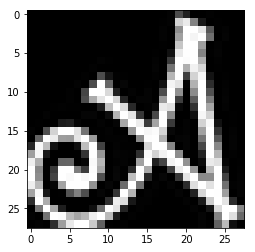

In [6]:
nb_classes = len(large_folders)
nb_samples_per_class = {}
for folder in large_folders:
    files = glob.glob(folder + "/*.png")
    nb_samples_per_class[folder[-1]] = len(files)
    
print("LARGE FOLDER :")
print("Number of classes :", nb_classes)
print("Number of samples per class :", nb_samples_per_class)
image = cv.imread(glob.glob(large_folders[0] + "/*.png")[0])
print("Images are of size :", image.shape)
print("Example :")
display_image(image);

SMALL FOLDER :
Number of classes : 10
Number of samples per class : {'A': 1873, 'B': 1873, 'C': 1873, 'D': 1873, 'E': 1873, 'F': 1873, 'G': 1872, 'H': 1872, 'I': 1872, 'J': 1872}
Images are of size : (28, 28, 3)
Example :


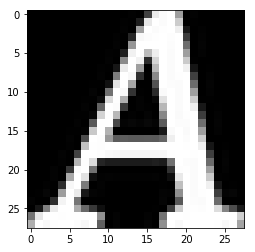

In [7]:
nb_classes = len(large_folders)
nb_samples_per_class = {}
for folder in small_folders:
    files = glob.glob(folder + "/*.png")
    nb_samples_per_class[folder[-1]] = len(files)
    
print("SMALL FOLDER :")
print("Number of classes :", nb_classes)
print("Number of samples per class :", nb_samples_per_class)
image = cv.imread(glob.glob(small_folders[0] + "/*.png")[0])
print("Images are of size :", image.shape)
print("Example :")
display_image(image);


Now that you have all your images set up we will load the data into a more manageable format. Since depending on your computer setup you might not be able to fit it all in memory, in here you will use a very useful dataformar in order to separate each class into a separate dataset, store them on disk and curate them independently. 

To do this we will use pickles.

https://docs.python.org/3.2/library/pickle.html

“Pickling” is the process whereby a Python object (it can be anything!) is converted into a byte stream (binary format), and “unpickling” is the inverse operation. We will use pickles to save the FULL set of images for each character in one pickle. The result will be a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make the training easier down the road. This process is known as "normalizing the data" or "feature scaling", which is very important to ensure convergence in the optimization step, as well to ensure that the feature space is well defined.

https://en.wikipedia.org/wiki/Feature_scaling


Your task, using the skeleton function bellow: 

* 1) Load all the images in FLOAT format for each class (A,..,J), 1 channel only.
* 2) Transform each image intensities such that the range goes from -125,125 (instead of 0, 256)
* 3) Scale the function so the new range goes from -0.5 to 0.5.

A few images might not be readable, we'll just skip them.

In [8]:

""" Image fixed size  """
image_size  = 28     # Pixel width and height. (28x28)
pixel_depth = 255.0  # Number of levels per pixel. (0,255)

""" There's should be enough data at the end"""
min_num_images_train = 45000;
min_num_images_test  = 1800;



def load_letter(folder, min_num_images):
    
    """ Base function: 

      Complete this function to read a each iamge of a given character (folder)
      Transforms and scale the image to have 0 mean and standard deviation of ~0.5.

      Params: 
          folder: input character folder (e.g. ../data/notMNIST_large/A/)
          min_num_images: minimum number of images you should have per character.

      returns: 
          dataset: Vector containing the fully loaded and scaled dataset.
    """


    image_files = os.listdir(folder)
    
    # Array size (should be preserved)  
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0

    # List of all the images inside the folder  
    for image in image_files:
        image_file = os.path.join(folder, image)
    
        # If the image is not loadable (there are some corrupted images you can skip them) 
        try:
          ##--- CODE HERE:
            image_data = np.float32(cv.imread(image_file, 0)) # Load in greyscale
            
            image_data = image_data - 128 # Set range to -128, 128
            image_data = image_data / 256 # set reange to -0.5, 0.5   
          ##--- End of your code.

          # here I check that you load them correctly and save it in the dataset array.  
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data

            num_images = num_images + 1
        
        #except IOError as e:
            #print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        except:
            print('Could not read:', image_file, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]

    # If this theshhold is not met, you are doind something wrong (probably)  
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
 
    #Check this output! 
    # The mean should be very close to 0 i.e < 1 and the std should be less than 0.5.  
    print('Full dataset tensor:', dataset.shape)
    
    # Notice we aree calling this a "tensor"
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset


In [9]:
# Look!, Morty, I'm a Pickle!        

# This function calls your pre-defined-function load_letter(folder, min_num_images) and creates the pickle!

def Im_a_pickle(data_folders, min_num_images_per_class, force=False):
    
    """ Base function: 
  
      Loads all the images listed in data_folders and creates a .pickle file
      
      Params: 
          data_folders: list of the folders to pickle (i.e. large_folders, small_folders)
          min_num_images: minimum number of images you should have per character.
      
      returns: 
          dataset_names: Vector containing all the pickles names.
  """
    dataset_names = []

    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
    
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
          print('%s already present - Skipping pickling.' % set_filename)
        else:
          print('Turning myself into a Pickle! %s.' % set_filename)

          dataset = load_letter(folder, min_num_images_per_class)

          try:
            with open(set_filename, 'wb') as f:
              pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
          except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

If everything was done correctly we can then call the following functions without error!

Notice that we are here considering the "large" data set as our training data set and the small as our test data set.

In [10]:
train_datasets = Im_a_pickle(large_folders, 45000)
test_datasets  = Im_a_pickle(small_folders, 1800)

../data/notMNIST_large/A.pickle already present - Skipping pickling.
../data/notMNIST_large/B.pickle already present - Skipping pickling.
../data/notMNIST_large/C.pickle already present - Skipping pickling.
../data/notMNIST_large/D.pickle already present - Skipping pickling.
../data/notMNIST_large/E.pickle already present - Skipping pickling.
../data/notMNIST_large/F.pickle already present - Skipping pickling.
../data/notMNIST_large/G.pickle already present - Skipping pickling.
../data/notMNIST_large/H.pickle already present - Skipping pickling.
../data/notMNIST_large/I.pickle already present - Skipping pickling.
../data/notMNIST_large/J.pickle already present - Skipping pickling.
../data/notMNIST_small/A.pickle already present - Skipping pickling.
../data/notMNIST_small/B.pickle already present - Skipping pickling.
../data/notMNIST_small/C.pickle already present - Skipping pickling.
../data/notMNIST_small/D.pickle already present - Skipping pickling.
../data/notMNIST_small/E.pickle al

---
## Problem 2

---------

To corroborate that our data is properly saved and scaled, display one example per class letter (A,...,J), from the train dataset **or** the test dataset. Include information about the new dynamic range of values of the images.

To do this, you will need to use the ``pickle.load(...)``. Check the documentation above for more details. You can use the inhered matplotlib function to show each example. Include a colorbar showing the __values range of the image__.

---

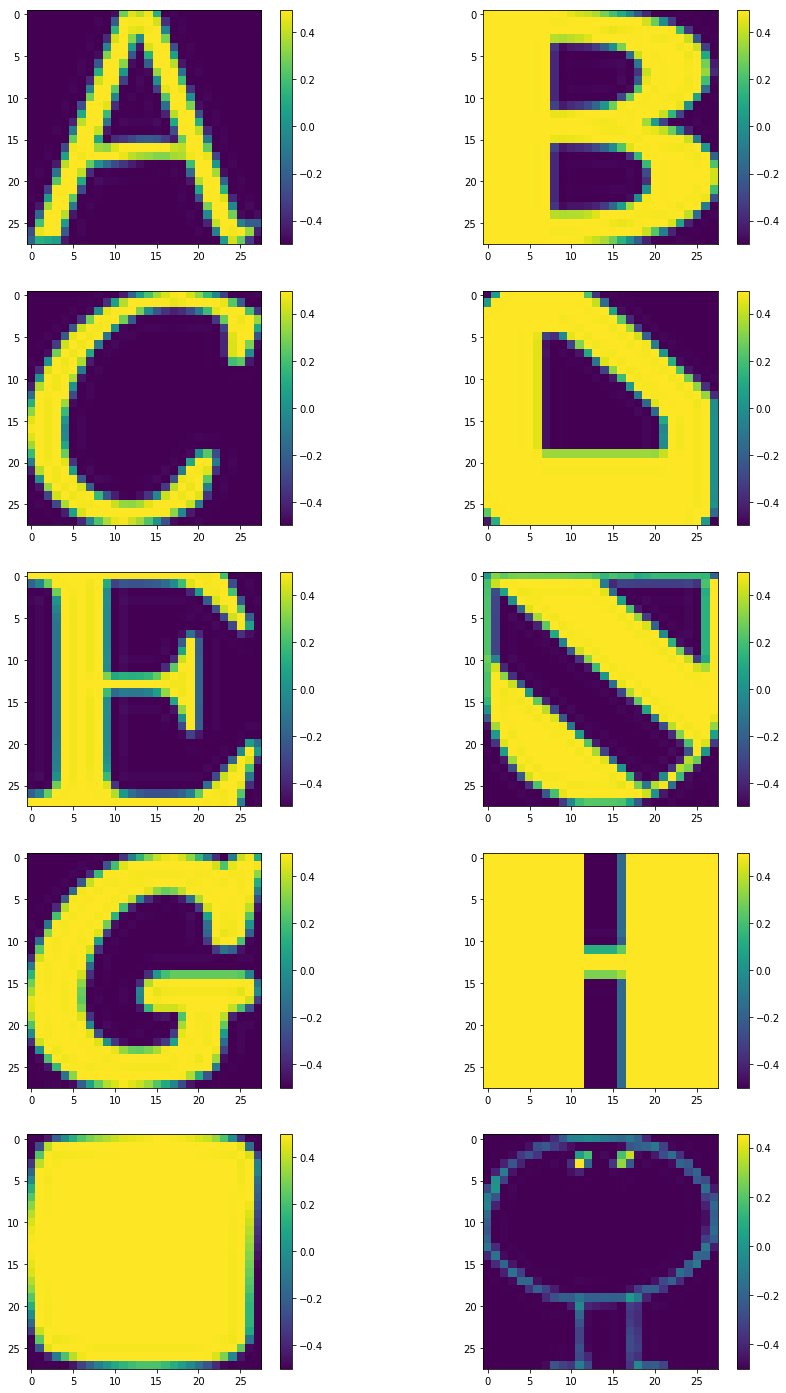

In [11]:
import random

i = 0
plt.figure(figsize=(15,25))
for filename in train_datasets:
    with open(filename, "rb") as input_file:
        i += 1
        plt.subplot(5,2,i)
        images = pickle.load(input_file)
        ex_idx = random.randint(0,len(images))
        plt.imshow(images[ex_idx,:,:]);
        plt.colorbar()
        


Finally if everything is correct, the above function should contain the full length of each character sample.  The labels will be stored into a separate array of *integers 0 through 9*.

Corroborate that the train_sets are in the order of ~52,000 images, and the train_set in the order of 1,870 images. 

In [12]:
def data_sets_sizes(data_set):
    
    number_files = [];

    """ Base function: 
  
      Loads all the images listed in data_set and return it' s size
    """
        
    for filename in data_set:
        with open(filename, "rb") as input_file:
            images = pickle.load(input_file)
            number_files.append(len(images))
        

    
    return number_files

print('The number of data of each class of train datasets is, ',data_sets_sizes(train_datasets))
print('The number of data of each class of test datasets is, ',data_sets_sizes(test_datasets))

The number of data of each class of train datasets is,  [52909, 52911, 52912, 52911, 52912, 52912, 52912, 52912, 52912, 52911]
The number of data of each class of test datasets is,  [1872, 1873, 1873, 1873, 1873, 1872, 1872, 1872, 1872, 1872]


## Problem 3 
### Creating sub-sampled datasets.


In order to evaluate the performance of our classifiers, we need to create subsets of our data properly randomized; this means that we shouldn't choose always the first set of images to compare since we will introduce a bias because of the sampled order. A very nice post on this topic can be found below in case you wonder if it's worth the trouble.

https://machinelearningmastery.com/randomness-in-machine-learning/


Here, you have to write a function: ``sample_training_data(...)`` which should create a training dataset of a given size, containing aprox. the same number of samples for each label (-1 or +1 samples) _randomly selected_ from the ``train-dataset``; as well as the labels of the training set coded as integers from 0 (A) to 9 (J). 

Is worth mentioning that is common practice in machine learning to set aside a third dataset known as the _validation dataset_. So, in addition, you will create this extra dataset which is used to prevent overfitting and other training problems. This dataset should __NOT__ contain any image used in the traning dataset. A nice and short explanation on why this is used is presetned below (it also contains nice code hints relevant to the exercise ;) )

https://machinelearningmastery.com/difference-test-validation-datasets/


In summary:

* Create a function that returns a subset of you data. 
* The function needs to ensure a balanced subset selection. 
* The function should also return (if needed) a validation dataset.
* The returned validation dataset must not contain any repeated sample from the training dataset. 



In [13]:
import random 


def sample_training_data(pickle_files, train_size, validation_size=0):

    """ Base function: 
  
      Given a train size and a validation size returns a ndarray containing a total of 
      <train_size/number_of_clases> samples, and <validation_size/number_of_clases> 
      samples for each class.
      
      Example: For a train_size = 100, validation_size = 0, the returned n_array should contain 100/10 = 10 
      samples of each character and no validation dataset. 
      
      The samples should be chose randomly.
      
      Params: 
          pickle_files: list of the pickle files (training set)
          train_size: total length of the new training set
          validation_size: total length of the validation set
      
      returns: 
          train_dataset: ndarray containing all the training images (properly normalized)
          train_labels : the labels of each selected image. 
          validation_dataset: ndarray containing all the validatiion images (properly normalized)
          validation_labels: the labels of each selected image. 
  """
    # Initialize the output dataset
    image_size = 28
    train_dataset = np.zeros((train_size,image_size,image_size))
    train_labels = np.zeros(train_size)
    
    validation_dataset = []
    validation_labels  = []
    
    if(validation_size>0):
        validation_dataset = np.zeros((validation_size,image_size,image_size))
        validation_labels = np.zeros(validation_size)
        
    class_label = 0
    for crt_class in pickle_files:
        with open(crt_class, "rb") as input_file:
            images = pickle.load(input_file)
            indexes = np.arange(len(images))
            random.shuffle(indexes)
            train_dataset[int(class_label*train_size/10):int((class_label+1)*train_size/10), :, :] = \
                images[indexes[:int(train_size/10)]]
            train_labels[int(class_label*train_size/10):int((class_label+1)*train_size/10)] = class_label
            
            if validation_size > 0:
                validation_dataset[int(class_label*validation_size/10):int((class_label+1)*validation_size/10), :, :] = \
                    images[indexes[int(train_size/10):int(train_size/10+validation_size/10)]]
                validation_labels[int(class_label*validation_size/10):int((class_label+1)*validation_size/10)] = \
                class_label       
            class_label += 1

    
    return train_dataset, train_labels, validation_dataset, validation_labels
  

# EXAMPLE OF USE
train_size = 20000
valid_size = 10000
test_size = 10000

train_dataset, train_labels, validation_dataset, validation_labels = sample_training_data(train_datasets, train_size,valid_size);

test_dataset, test_labels, _, _ = sample_training_data(test_datasets, test_size);

print('Training size: ', train_dataset.shape, '\nLabel vector size:',train_labels.shape)
print('Testing size: ', test_dataset.shape, '\nLabel vector size:',test_labels.shape)
print('Validation size: ', validation_dataset.shape, '\nLabel vector size:',test_labels.shape)


Training size:  (20000, 28, 28) 
Label vector size: (20000,)
Testing size:  (10000, 28, 28) 
Label vector size: (10000,)
Validation size:  (10000, 28, 28) 
Label vector size: (10000,)


Finally, you need to randomize the vector so it doesn't follow any specific order: like first all the A characters and then the 'B' characters, and so on 

```(A, A, ..., A , B, B, ..., B, C, C, ...,C,... )```.


In [14]:
# Define a function to randomize THE ORDER of a given dataset.
# Be sure that the dataset and the labels are shuffled in the same order so they MATCH.

def randomize(dataset, labels):
    
    indexes = np.arange(len(dataset))
    random.shuffle(indexes)
    shuffled_dataset = dataset[indexes,:,:]
    shuffled_labels = labels[indexes]
    
    return shuffled_dataset, shuffled_labels


# Shuffle the three datasets  sets
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels   = randomize(test_dataset, test_labels)
validation_dataset, validation_labels  = randomize(validation_dataset, validation_labels)

---
Problem 4
---------

Show us that your method works and all the datasets are coherent with the labels. You can display the shuffled order and show the first images for the three datasets. They should match the labels.

---

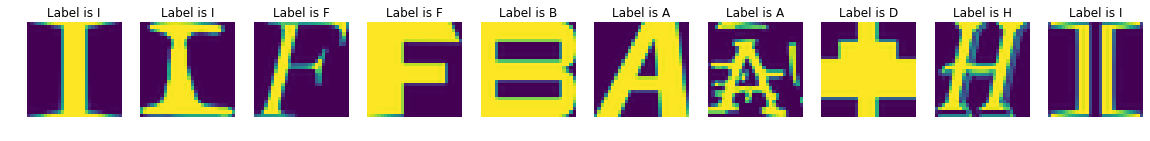

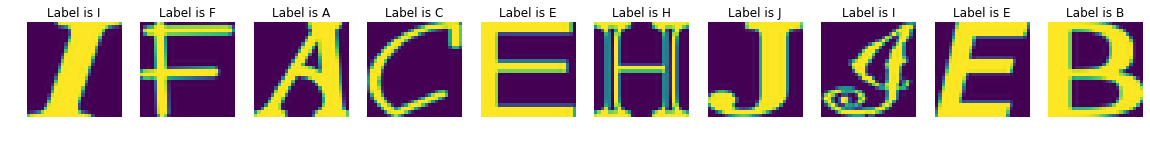

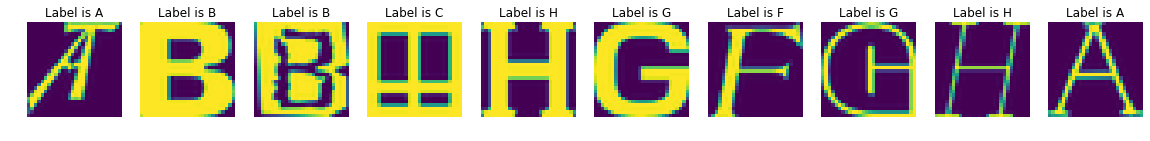

In [15]:
letter_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

def show_first_samples(dataset, labels):
    plt.figure(figsize=(20,5))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(dataset[i,:,:])
        plt.axis('off')
        plt.title("Label is {}".format(letter_labels[int(labels[i])]))
    return

show_first_samples(train_dataset, train_labels)
show_first_samples(test_dataset, test_labels)
show_first_samples(validation_dataset, validation_labels)

---
Problem 5
---------

By default, this dataset might contain a lot of overlapping samples (repeated images with different names). As explaining before, this overlap between training, test and validation, can skew the results and cause overfitting. 

To ensure this doesn't happend, measure how much overlap there is between training, validation and test samples. 

- Check for overlapping samples in your dataset using any metric that you would like. Take into account that, if you use a computational expensive metric, this process will take very long times. Consider using a _clever_ and fast metric.

- Modify your ``sample_training_data``function and provide a curated train, validation and test dataset removing repeated samples from one of them.  Write the new function bellow.
---

In [16]:
def check_overlapping(dataset, labels):
    overlap = 0
    overlap_list = {}
    
    for crt_class in range(10):
        hash_dict = {}
        overlap_list[crt_class] = []
        images = dataset[labels == crt_class,:,:]
        for idx, img in enumerate(images):
            k = np.sum(img)
            if k in hash_dict.keys():
                bool_overlap = False
                for idx_2 in hash_dict[k]:
                    if not np.any(cv2.subtract(img, images[idx_2])):
                        bool_overlap = True
                        break
                if bool_overlap:
                    overlap += 1
                    overlap_list[crt_class].append((idx, idx_2))
                else:
                    hash_dict[k].append(idx)
            else:
                hash_dict[k] = [idx]
    return overlap, overlap_list

whole_dataset = np.concatenate((train_dataset, test_dataset, validation_dataset))
whole_labels = np.concatenate((train_labels, test_labels, validation_labels))
overlap, overlap_list = check_overlapping(whole_dataset, whole_labels)

print("Total overlap : {} over {} pictures".format(overlap, len(whole_dataset)))

Total overlap : 969 over 40000 pictures


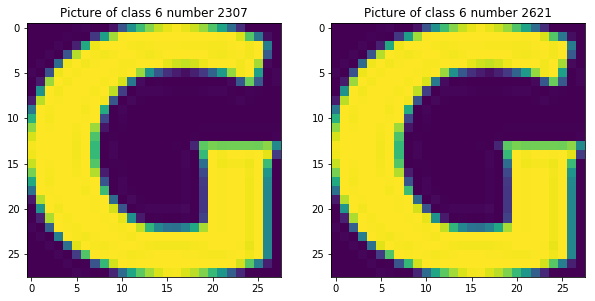

In [17]:
crt_class = random.randint(0,9)
test_idx = random.randint(0,len(overlap_list[crt_class])-1)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(whole_dataset[whole_labels == crt_class,:,:][overlap_list[crt_class][test_idx][1],:,:])
plt.title("Picture of class {} number {}".format(crt_class, overlap_list[crt_class][test_idx][1]))

plt.subplot(1,2,2)
plt.imshow(whole_dataset[whole_labels == crt_class,:,:][overlap_list[crt_class][test_idx][0],:,:])
plt.title("Picture of class {} number {}".format(crt_class, overlap_list[crt_class][test_idx][0]));


In [18]:
def masks_of_non_overlap(train_images, test_images):
    train_mask = np.ones(len(train_images), dtype=bool)
    test_mask = np.ones(len(test_images), dtype=bool)
    train_hash_dict = {}
    test_hash_dict = {}
    
    for idx, img in enumerate(train_images):
        k = np.sum(img)
        if k in train_hash_dict.keys():
            bool_overlap = False
            for idx_2 in train_hash_dict[k]:
                if not np.any(cv2.subtract(img, train_images[idx_2])):
                    bool_overlap = True
                    break
            if bool_overlap:
                train_mask[idx] = False
            else:
                train_hash_dict[k].append(idx)
        else:
            train_hash_dict[k] = [idx]
            
    for idx, img in enumerate(test_images):
        k = np.sum(img)
        if k in train_hash_dict.keys():
            bool_overlap = False
            for idx_2 in train_hash_dict[k]:
                if not np.any(cv2.subtract(img, train_images[idx_2])):
                    bool_overlap = True
                    break
            if bool_overlap:
                test_mask[idx] = False
        if k in test_hash_dict.keys():
            bool_overlap = False
            for idx_2 in test_hash_dict[k]:
                if not np.any(cv2.subtract(img, test_images[idx_2])):
                    bool_overlap = True
                    break
            if bool_overlap:
                test_mask[idx] = False
            else:
                test_hash_dict[k].append(idx)        
        else:
            test_hash_dict[k] = [idx]
    return train_mask, test_mask

In [19]:
def sample_training_data(train_pickle_files, train_size, test_pickle_files, test_size, validation_size=0):

    """ Base function: 
  
      Given a train size, test size and a validation size returns a ndarray containing a total of 
      <train_size/number_of_clases> samples, <test_size/number_of_clases> samples, 
      and <validation_size/number_of_clases>  samples for each class.
      
      Example: For a train_size = 100, validation_size = 0, the returned n_array should contain 100/10 = 10 
      samples of each character and no validation dataset. 
      
      The samples should be chose randomly.
      
      Params: 
          train_pickle_files: list of the pickle files (training set)
          train_size: total length of the new training set
          test_pickle_files: list of the pickle files (testing set)
          test_size: total length of the new testing set
          validation_size: total length of the validation set
      
      returns: 
          train_dataset: ndarray containing all the training images (properly normalized)
          train_labels : the labels of each selected image. 
          validation_dataset: ndarray containing all the validatiion images (properly normalized)
          validation_labels: the labels of each selected image. 
          test_dataset: ndarray containing all the test images (properly normalized)
          test_labels: the labels of each selected image. 
  """
    # Initialize the output dataset
    image_size = 28
    train_dataset = np.zeros((train_size,image_size,image_size))
    train_labels = np.zeros(train_size)
    
    test_dataset = np.zeros((test_size,image_size,image_size))
    test_labels = np.zeros(test_size)
    
    validation_dataset = []
    validation_labels  = []
    
    if(validation_size>0):
        validation_dataset = np.zeros((validation_size,image_size,image_size))
        validation_labels = np.zeros(validation_size)
        
    class_label = 0
    for idx in range(len(train_pickle_files)):
        with open(train_pickle_files[idx], "rb") as train_input_file:
            with open(test_pickle_files[idx], "rb") as test_input_file:
                train_images = pickle.load(train_input_file)
                train_indexes = np.arange(len(train_images))
                test_images = pickle.load(test_input_file)
                test_indexes = np.arange(len(test_images))
                
                train_mask, test_mask = masks_of_non_overlap(train_images, test_images)
                
                train_indexes = train_indexes[train_mask]
                random.shuffle(train_indexes)
                test_indexes = test_indexes[test_mask]
                random.shuffle(test_indexes)
                
                train_dataset[int(class_label*train_size/10):int((class_label+1)*train_size/10), :, :] = \
                    train_images[train_indexes[:int(train_size/10)]]
                train_labels[int(class_label*train_size/10):int((class_label+1)*train_size/10)] = class_label
                
                test_dataset[int(class_label*test_size/10):int((class_label+1)*test_size/10), :, :] = \
                    test_images[test_indexes[:int(test_size/10)]]
                test_labels[int(class_label*test_size/10):int((class_label+1)*test_size/10)] = class_label

                if validation_size > 0:
                    validation_dataset[int(class_label*validation_size/10):int((class_label+1)*validation_size/10), :, :] = \
                        train_images[train_indexes[int(train_size/10):int(train_size/10+validation_size/10)]]
                    validation_labels[int(class_label*validation_size/10):int((class_label+1)*validation_size/10)] = \
                    class_label       
                class_label += 1

    
    return train_dataset, train_labels, validation_dataset, validation_labels, test_dataset, test_labels
  

# EXAMPLE OF USE
train_size = 20000
valid_size = 10000
test_size = 10000

train_dataset, train_labels, validation_dataset, validation_labels, test_dataset, test_labels = \
    sample_training_data(train_datasets, train_size, test_datasets, test_size, valid_size);

# Shuffle the three datasets  sets
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels   = randomize(test_dataset, test_labels)
validation_dataset, validation_labels  = randomize(validation_dataset, validation_labels)

print('Training size: ', train_dataset.shape, '\nLabel vector size:',train_labels.shape)
print('Testing size: ', test_dataset.shape, '\nLabel vector size:',test_labels.shape)
print('Validation size: ', validation_dataset.shape, '\nLabel vector size:',test_labels.shape)


Training size:  (20000, 28, 28) 
Label vector size: (20000,)
Testing size:  (10000, 28, 28) 
Label vector size: (10000,)
Validation size:  (10000, 28, 28) 
Label vector size: (10000,)


In [20]:
whole_dataset = np.concatenate((train_dataset, test_dataset, validation_dataset))
whole_labels = np.concatenate((train_labels, test_labels, validation_labels))
overlap, overlap_list = check_overlapping(whole_dataset, whole_labels)

print("Total overlap : {} over {} pictures".format(overlap, len(whole_dataset)))

Total overlap : 0 over 40000 pictures


---
Problem 6
---------

Let's get an idea of what a basic classifier can give you on this data. 

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 

Hint: you can use the ```LogisticRegression``` or ```LogisticRegressionCv``` model from sklearn.linear_model.

Provide a score for the prediction over the full test data set. You can use any metric from the previous chapters or an implemented one like the ```cross_val_score``` form sklearn which is more accurate.

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

A good choice of parameters (and regularization method) can give you results up to the 89%

```
#Samples: 50 ---> Score: 0.471428571429
#Samples: 100 ---> Score: 0.605865717935
#Samples: 1000 ---> Score: 0.760772183027
#Samples: 5000 ---> Score: 0.812826972435 
```


When you optimize the parameters, be sure to do it only to improve the results on the test dataset, and never use the validation dataset (otherwise it loses it purpuse).






---

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def train_and_validate(num_examples):
    
    # Get num_examples indexes from training set
    indexes = np.arange(len(train_dataset))
    random.shuffle(indexes)
    indexes = indexes[:num_examples]
    
    # First, reshaping the input data
    reshaped_train_dataset = train_dataset[indexes, :, :].reshape(num_examples, -1)
    len_test_dataset = test_dataset.shape[0]
    reshaped_test_dataset = test_dataset.reshape(len_test_dataset, -1)
    
    # Creating the Logistic Regression Classifier
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=500)
    
    # Train our classifier
    clf.fit(reshaped_train_dataset, train_labels[indexes])
    
    # Test the performances of our classifier on the test dataset via cross_val_score
    #score = cross_val_score(clf, reshaped_test_dataset, test_labels, cv=3)
    
    # Cross_val_score has no sense if we limit the number of training data samples
    return clf.score(reshaped_test_dataset, test_labels)

In [22]:
training_sizes = [50, 100, 1000, 5000]

print("Cross Validation Score\n")
for size in training_sizes:
    score = train_and_validate(size)
    print("Samples:", size,"---> Score:", score)
    
    
#Samples: 50 ---> Score: 0.471428571429
#Samples: 100 ---> Score: 0.605865717935
#Samples: 1000 ---> Score: 0.760772183027
#Samples: 5000 ---> Score: 0.812826972435


Cross Validation Score

Samples: 50 ---> Score: 0.5975
Samples: 100 ---> Score: 0.7422
Samples: 1000 ---> Score: 0.8007
Samples: 5000 ---> Score: 0.8129


# Part 2) Deep Learning - Intro to Deep Neural Networks

## Simple Linear Model and Multi-layer Perceptron (MLP)


## Introduction

In the last couple of years, deep learning has produced state-of-the-art results in many computer vision tasks. In this section, a practical overview of deep Learning's basic concepts has been provided and we are going to work with a simple linear and multi-layer perceptron (MLP) models.

At its core, deep learning is a class of neural network models. That is a model with an input layer, an output layer, and an arbitrary number of hidden layers. These layers are made up of neurons or neural units. They are called neurons because they share some similarities with the behaviour of the neurons present in the human brain. For our purposes, we can think of a neuron as a nonlinear function of the weighted sum of its inputs. Since the neuron is really the most basic part of any deep learning model it is a good place to start. 

As the starting point, we continue to work the notMNIST dataset. After loading the dataset, we define and optimize a simple mathematical model in TensorFlow. The results are then plotted and discussed. First, we import tensorflow with other needed packages:

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [24]:
tf.__version__

'1.13.1'

Using your function defined above create a training, test, and validation dataset. The dataset should be splitted into 3 mutually exclusive sub-sets (200000 training images, 10000 validation and 10000 test images, respectively). You can display the images in each sub-set. They should match the labels.

In [25]:
#Code here:
train_dataset, train_labels, validation_dataset, validation_labels, test_dataset, test_labels = \
    sample_training_data(train_datasets, train_size, test_datasets, test_size, valid_size);

# Shuffle the three datasets  sets
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels   = randomize(test_dataset, test_labels)
validation_dataset, validation_labels  = randomize(validation_dataset, validation_labels)

# Display the openend files
print("Training Set ", train_dataset.shape, train_labels.shape)
print("Validation Set", validation_dataset.shape, validation_labels.shape)
print("Test Set", test_dataset.shape,test_labels.shape)


#Training Set  (20000, 28, 28) (20000,)
#Validation Set (10000, 28, 28) (10000,)
#Test Set (10000, 28, 28) (10000,)

Training Set  (20000, 28, 28) (20000,)
Validation Set (10000, 28, 28) (10000,)
Test Set (10000, 28, 28) (10000,)


In [26]:
IMAGE_SIZE = 28
IMAGE_SHAPE=(IMAGE_SIZE,IMAGE_SIZE)

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(IMAGE_SHAPE), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

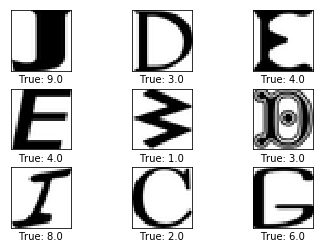

In [27]:
# Get the first images from the test-set.
images = test_dataset[0:9]

# Get the true classes for those images.
cls_true = test_labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### One-Hot Encoding and Image Flattened Mode

Our labels contain a list of predictions for our examples, e.g. [1, 9, ...]. In tensorflow and many other machine learning API's, the label has to be converted to the encoding format as so-called One-Hot encoding. This means the labels have been converted from a single number to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is one and means the class is $i$.

In addition, because we are going to use linear layers and multiplications of the neural network, you always want your data to be a (1 or) 2-dimensional matrix, where each row is the vector representing your data. Therefore, it would be more complicated and less efficient without reshaping images first. Here, we need to flatten images before passing them to our model. As an example, please print out the One-Hot encoded labels for the first 5 images in the test set.


In [28]:
def reformat(dataset, labels):
    """
        Reformat the data to the one-hot and flattened mode
    """
    n_dataset = dataset.reshape((-1, IMAGE_SIZE * IMAGE_SIZE)).astype(np.float32)

    # Convert to the one hot format
    n_labels = (np.arange(NUM_LABELS) == labels[:, None]).astype(np.float32)

    return n_dataset, n_labels


NUM_LABELS = 10

TRAIN_DATASET, TRAIN_LABELS = reformat(train_dataset, train_labels)
VALID_DATASET, VALID_LABELS = reformat(validation_dataset, validation_labels)
TEST_DATASET, TEST_LABELS = reformat(test_dataset, test_labels)

# Display the files
print("Training Set ", TRAIN_DATASET.shape, TRAIN_LABELS.shape)
print("Validation Set", VALID_DATASET.shape, VALID_LABELS.shape)
print("Test Set", TEST_DATASET.shape, TEST_LABELS.shape)

Training Set  (20000, 784) (20000, 10)
Validation Set (10000, 784) (10000, 10)
Test Set (10000, 784) (10000, 10)


In [29]:
TEST_LABELS[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain rule for derivatives.


A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to change the input to the graph.
* Model variables that are going to be optimised to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements, e.g. for logging data to be displayed using TensorBoard, which is not covered here.

### Default graph

As the starting point, we create a new computational graph via the `tf.Graph` constructor. To add operations to this graph, we must register it as the default graph. The way the TensorFlow API is designed, library routines that create new operation nodes always attach these to the current default graph. We register our graph as the default by using it as a Python context manager in a `with-as` statement.


## Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First, we define the placeholder variable for the input images including train and validation set. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, IMAGE_SIZE_FLAT]`, where `None` means that the tensor may hold an arbitrary number of images with each image being reshaped into a vector of length `IMAGE_SIZE_FLAT` which is equal to IMAGE_SIZE * IMAGE_SIZE. In addition, we create a constant tensor for the validation and test set since they are fixed and will be evaluated later.   


Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable TF_TRAIN_DATASET. The shape of this placeholder variable is [None, NUM_LABELS] which means it may hold an arbitrary number of labels and each label is a vector of length NUM_LABELS which is 10 in this case.

### Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow to make the model perform better on the training data.

In fact, the model variables are the network hidden layer parameters including layer's weights and biases. The first variable that must be optimized are WEIGHTS and defined here as a TensorFlow variable that must be initialized and whose shape is [IMAGE_SIZE_FLAT, NUM_LABELS] for the simple linear model, so it is a 2-dimensional tensor (or matrix) with IMAGE_SIZE_FLAT rows and NUM_LABELS columns. There are various ways to initialize the weights like initialization with zeros tf.zeros, tf.truncated_normal and tf.random_normal, which output random values from a normal distribution and you can specify the mean and The standard deviation (stddev) of the normal distribution.

The second variable that must be optimized is called BIASES and is defined as a 1-dimensional tensor (or vector) of length NUM_LABELS.

Last but not least, you should name every important operation in your code. In complex models, it is good practice to use scopes. The important point is that if you want to later use some operation, you have to either name it or put it into a collection.


### Model

This simple mathematical model multiplies the training images in the placeholder variable TF_TRAIN_DATASET with the WEIGHTS and then adds the BIASES.

The result is a matrix of shape [NUM_IMAGES, NUM_LABELS] because TF_TRAIN_DATASET has shape [NUM_IMAGES, IMAGE_SIZE_FLAT] and WEIGHTS has shape [IMAGE_SIZE_FLAT, NUM_LABELS], so the multiplication of those two matrices is a matrix with shape [NUM_IMAGES, NUM_LABELS] and then the BIASES vector is added to each row of that matrix.

However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the LOGITS matrices sums to one (see below code), and each element is limited between zero and one. This is calculated using the so-called softmax function tf.nn.softmax.


### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for `WEIGHTS` and `BIASES`. To do this, we first need to know how well the model currently performs by comparing the predicted output of the model to the desired output.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is, therefore, to minimise the cross-entropy, so it gets as close to zero as possible by changing the `WEIGHTS` and `BIASES` of the model.

TensorFlow has a built-in function for calculating the cross-entropy using `tf.nn.softmax_cross_entropy_with_logits`. Note that it uses the values of the `LOGITS` in train, validation and test sets because it also calculates the softmax internally. In order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy using (`tf.reduce_mean`) for all the image classifications.

### Optimization method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [30]:
IMAGE_SIZE_FLAT=IMAGE_SIZE * IMAGE_SIZE

# Create a new graph
GRAPH = tf.Graph()

# Register the graph as the default one to add nodes
with GRAPH.as_default():
    
    # Define placeholders
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE * IMAGE_SIZE))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))
    TF_VALID_DATASET = tf.constant(VALID_DATASET)
    TF_TEST_DATASET = tf.constant(TEST_DATASET)
    
    with tf.name_scope("Linear_model"):
        
        """
           Initialize weights and biases
        """
        
        WEIGHTS = tf.Variable(tf.random_normal(shape=[IMAGE_SIZE_FLAT, NUM_LABELS], stddev=0.1))
        BIASES = tf.Variable(tf.zeros([NUM_LABELS]))
    
        """
           Compute the logits WX + b
        """ 
        TRAIN_LOGITS = tf.matmul(TF_TRAIN_DATASET, WEIGHTS) + BIASES
        VALID_LOGTIS = tf.matmul(TF_VALID_DATASET, WEIGHTS) + BIASES
        TEST_LOGITS = tf.matmul(TF_TEST_DATASET, WEIGHTS) + BIASES
    
        """
           Softmax function
        """   
        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        VALID_PREDICTION = tf.nn.softmax(VALID_LOGTIS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
    
        """
           Cost-function
        """
        CROSS_ENTROPY= tf.nn.softmax_cross_entropy_with_logits_v2(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS)
        COST= tf.reduce_mean(CROSS_ENTROPY)
        # Optimizer
        OPTIMIZER = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(COST)

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
def accuracy(predictions, labels):
    """
        Divides the number of true predictions to the number of total predictions
    """
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def print_confusion_matrix(predictions, labels):

    # Convert the One-Hot encoded vectors to a single number by taking the index of the highest element
    labels=np.array([label.argmax() for label in labels])
    predictions = np.array([prediction.argmax() for prediction in predictions])

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels,
                          y_pred=predictions)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(NUM_LABELS)
    plt.xticks(tick_marks, range(NUM_LABELS))
    plt.yticks(tick_marks, range(NUM_LABELS))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    plt.show()

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph and train our model. For this, we enter a session environment using a `tf.Session` as a context manager. We pass our graph  object to its constructor, so that it knows which graph to manage. To then execute nodes, we have several options. The   most general way is to call Session.run() and pass a list of tensors we wish to compute. Alternatively, we may call `eval()` on  tensors and `run()` on  operations directly.

Before evaluating any other node, we must first ensure that the variables in our graph are initialized. Theoretically,  we could `run` the `Variable.initializer` operation for each variable. However, one most often just uses the
`tf.initialize_all_variables()` utility operation provided by TensorFlow, which in turn executes the `initializer` 
operation for each `Variable` in the graph. Then, we can perform a certain number of iterations of stochastic gradient  descent, fetching an example and label from the notMNIST dataset each time and feeding it to the run routine. 

One important point is that, there are 200,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [32]:
BATCH_SIZE = 32
NUM_ITERATIONS = 20000

Variables initialized
Minibatch loss at step  0 :  2.8454802
Minibatch accuracy:  6.25
Validation accuracy:  28.41
Minibatch loss at step  500 :  0.6092421
Minibatch accuracy:  81.25
Validation accuracy:  76.84
Minibatch loss at step  1000 :  1.1434793
Minibatch accuracy:  68.75
Validation accuracy:  76.37
Minibatch loss at step  1500 :  0.7826774
Minibatch accuracy:  71.875
Validation accuracy:  76.81
Minibatch loss at step  2000 :  1.2069838
Minibatch accuracy:  75.0
Validation accuracy:  77.21
Minibatch loss at step  2500 :  0.88950515
Minibatch accuracy:  71.875
Validation accuracy:  77.6
Minibatch loss at step  3000 :  0.8751191
Minibatch accuracy:  71.875
Validation accuracy:  75.2
Minibatch loss at step  3500 :  0.7672682
Minibatch accuracy:  75.0
Validation accuracy:  74.92
Minibatch loss at step  4000 :  0.28196746
Minibatch accuracy:  93.75
Validation accuracy:  78.28
Minibatch loss at step  4500 :  0.95913804
Minibatch accuracy:  75.0
Validation accuracy:  77.07
Minibatch lo

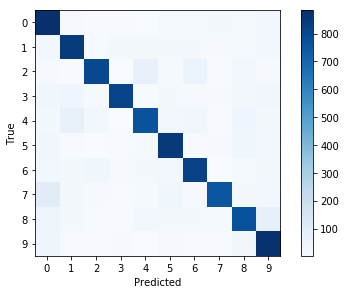

In [33]:

with tf.Session(graph=GRAPH) as session:
    """
        Start the above variable initialization
    """
    init = tf.global_variables_initializer()
    session.run(init)

    print("Variables initialized")

    for step in range(NUM_ITERATIONS):
        """
            Generate a random base and then generate a minibatch
        """
        BASE = (step * BATCH_SIZE) % (TRAIN_LABELS.shape[0] - BATCH_SIZE)
        BATCH_DATA = TRAIN_DATASET[BASE:(BASE + BATCH_SIZE), :]
        BATCH_LABELS = TRAIN_LABELS[BASE:(BASE + BATCH_SIZE), :]
        """
            Feed the current session with batch data
        """
        FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
        _, l, predictions = session.run([OPTIMIZER, COST, TRAIN_PREDICTION], feed_dict=FEED_DICT)

        if(step % 500 == 0):
            print("Minibatch loss at step ", step, ": ", l)
            print("Minibatch accuracy: ", accuracy(predictions, BATCH_LABELS))
            print("Validation accuracy: ", accuracy(VALID_PREDICTION.eval(), VALID_LABELS))
            
        if (step == NUM_ITERATIONS-1):
            print("Test accuracy: ", accuracy(TEST_PREDICTION.eval(), TEST_LABELS))
            print_confusion_matrix(TEST_PREDICTION.eval(), TEST_LABELS)

## Problem 7: Comment on the accuracy of the classifier, what is the meaning of each entry, and comment the confussion matrix results. 

The accuracy of the classifier is very good on the test dataset after 20000 iterations, around 80%: it means that more than three times out of four, the classifier correctly guesses to what number the drawn image corresponds.


Every 500 iterations, we print the minibatch loss (the cross-entropy mentionned above), as well as the accuracy on the batch of the train dataset used for this iteration and the accuracy on the validation dataset. In the end, the accuracy is plotted on the test dataset (not used until the end of the optimization process).


The confusion matrix plotted in the end gives us the repartition of predicted labels for each true class label. Each row corresponds to a class label composed of 1000 images, and for each class label the number of images predicted in each class. Thus, each square on the diagonal of the matrix gives us the number of correct classified predicted labels for each true class. The perfect classifier would have a confusion matrix with only squares on the diagonal, as every square out of the diagonal corresponds to images wrongly classified.


We notably observe three squares out of the diagonal. One for row 6 and column 2 : it represents the 'G' letter images classified as 'C'. Another one for row 5 and column 4 corresponding to the 'F' classified as 'E'. Another one for row 8 and column representing the 'I' letter images classified as 'J'. We can understand that by the fact that both for 'G' and 'C', for 'F' and 'E, and for 'I' and 'J', the letters are morphologically similar, and depending on the type of typology the classifier can easily confuse the two. Apart from those, most of the images are correctly classified.

## Multilayer Perceptron (MLP)

The next architecture we are going to work with is multilayer perceptron (MLP). An MLP can be viewed as a logistic regression classifier where the input is first transformed using some non-linear transformations of the intermediate network layers. These intermediate layers are referred to as a `hidden layers`. Here, we are going to define TF graph for the MLP model with two hidden layers and one output layer. First, let’s draw the model the MLP represents:


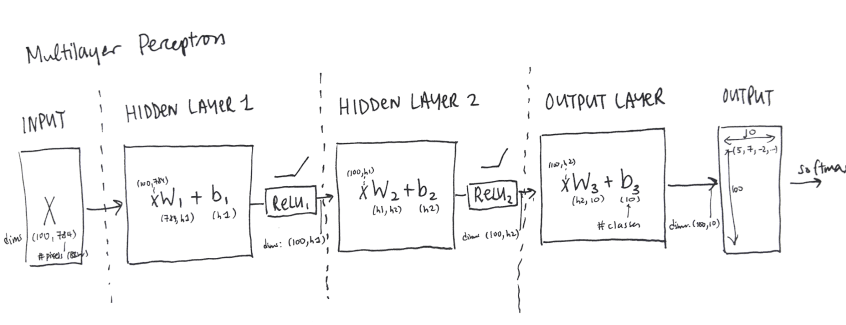

In [34]:
from IPython.core.display import Image 
Image(filename='../data/multilayer-perceptron-drawing.png')

## Problem 8

In our example above, the MLP model has two hidden layers with sizes of `HIDDEN_NODES_1=102` and `HIDDEN_NODES_2=51`, respectively. In a MLP, every element of a previous layer is connected to every element of the next layer. For example, the weights in the second hidden layer has `shape=[HIDDEN_NODES_1, HIDDEN_NODES_2]`. 

Now, lets define MLP graph with two hidden layers (in the following exercise you should only use train and test sets):

In [35]:
#Define the number of nodes for the hidden layers
HIDDEN_NODES_1=102
HIDDEN_NODES_2=51

MLP_GRAPH = tf.Graph()

IMAGE_SIZE_FLAT = IMAGE_SIZE * IMAGE_SIZE

#Code Here.
with MLP_GRAPH.as_default():
    
    # Define placeholders
    TF_TRAIN_DATASET = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE * IMAGE_SIZE))
    TF_TRAIN_LABELS = tf.placeholder(tf.float32, shape=(None, NUM_LABELS))
    TF_TEST_DATASET = tf.constant(TEST_DATASET)
    
    with tf.name_scope("Linear_model"):
                        
        """
           Initialize weights and biases for the 3 Layers
        """
        
        WEIGHTS = {
            'h1': tf.Variable(tf.random_normal([IMAGE_SIZE_FLAT, HIDDEN_NODES_1])),
            'h2': tf.Variable(tf.random_normal([HIDDEN_NODES_1, HIDDEN_NODES_2])),
            'out': tf.Variable(tf.random_normal([HIDDEN_NODES_2, NUM_LABELS]))
        }        
        
        BIASES = {
            'b1' : tf.Variable(tf.zeros([HIDDEN_NODES_1])),
            'b2': tf.Variable(tf.zeros([HIDDEN_NODES_2])),
            'out': tf.Variable(tf.zeros([NUM_LABELS]))
        }       
                
            
        """
           Compute the logits WX + b
        """ 
        
        LAYER_1 = tf.nn.relu(tf.matmul(TF_TRAIN_DATASET, WEIGHTS['h1']) + BIASES['b1'])
        LAYER_2 = tf.nn.relu(tf.matmul(LAYER_1, WEIGHTS['h2']) + BIASES['b2'])
        TRAIN_LOGITS = tf.matmul(LAYER_2, WEIGHTS['out']) + BIASES['out']
        
        LAYER_1_TEST = tf.nn.relu(tf.matmul(TF_TEST_DATASET, WEIGHTS['h1']) + BIASES['b1'])
        LAYER_2_TEST = tf.nn.relu(tf.matmul(LAYER_1_TEST, WEIGHTS['h2']) + BIASES['b2'])
        TEST_LOGITS = tf.matmul(LAYER_2_TEST, WEIGHTS['out']) + BIASES['out']  
        
        """
           Softmax function
        """   
        
        TRAIN_PREDICTION = tf.nn.softmax(TRAIN_LOGITS)
        TEST_PREDICTION = tf.nn.softmax(TEST_LOGITS)
    
        """
           Cost-function
        """
        CROSS_ENTROPY= tf.nn.softmax_cross_entropy_with_logits_v2(logits=TRAIN_LOGITS, labels=TF_TRAIN_LABELS)
        COST= tf.reduce_mean(CROSS_ENTROPY)
        # Optimizer
        OPTIMIZER = tf.train.AdamOptimizer(learning_rate=0.001).minimize(COST)

## Problem 9

As mentioneded before, in an MLP, the number of parameters (weights w_i and b_i)to learn is poportional to the number of layers and neurons on each of those layers. In here make the computation of the number of parameters for the network that you constructed above.


We have 3 Layers and the following parameters for each : 
1. : the weight matrix of size IMAGE_SIZE by HIDDEN_NODES_1 and the bias vector of size HIDDEN_NODES_1
2. : the weight matrix of size HIDDEN_NODES_1 by HIDDEN_NODES_2 and the bias vector of size HIDDEN_NODES_2
3. : the weight matrix of size HIDDEN_NODES_2 by NUM_LABELS and the bias vector of size NUM_LABELS


The following computation gives us the total number of parameters of our MLP.

In [36]:
IMAGE_SIZE_FLAT = 784
HIDDEN_NODES_1 = 102
HIDDEN_NODES_2 = 51
NUM_LABELS = 10

In [37]:
param_layer_1 = IMAGE_SIZE_FLAT*HIDDEN_NODES_1 + HIDDEN_NODES_1
param_layer_2 = HIDDEN_NODES_1*HIDDEN_NODES_2 + HIDDEN_NODES_2
param_output = HIDDEN_NODES_2*NUM_LABELS + NUM_LABELS
total_param = param_layer_1 + param_layer_2 + param_output
print('Number of parameters in the MLP : ', total_param)

Number of parameters in the MLP :  85843


### Helper-function to perform optimization iterations

Here, we build a function for performing a number of optimization iterations so as to gradually improve the weights and biases of the MLP model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The inputs of the function are the number of iterations `NUM_ITERATIONS` and number of used samples `NUM_SAMPLES` to train the model

In [38]:
def optimize(NUM_ITERATIONS, NUM_SAMPLES):
    
    with tf.Session(graph=MLP_GRAPH) as session:

        """
            Start the above variable initialization
        """
        # tf.initialize_all_variables().run()  
        tf.global_variables_initializer().run()

        print("Variables initialized")

        for step in range(NUM_ITERATIONS):
            """
                Select the desired samples
            """
            TRAIN_DATASET_S = TRAIN_DATASET[:NUM_SAMPLES]
            TRAIN_LABELS_S = TRAIN_LABELS[:NUM_SAMPLES]
            """
                Generate a random base and then generate a minibatch
            """
            
            indices = np.random.choice(range(TRAIN_LABELS_S.shape[0]
                                             ), BATCH_SIZE)
            BATCH_DATA = TRAIN_DATASET_S[indices, :]
            BATCH_LABELS = TRAIN_LABELS_S[indices, :]

            """
                Feed the current session with batch data
            """
            FEED_DICT = {TF_TRAIN_DATASET: BATCH_DATA, TF_TRAIN_LABELS: BATCH_LABELS}
            _, l, predictions = session.run([OPTIMIZER, COST, TRAIN_PREDICTION], feed_dict=FEED_DICT)

            if (step == NUM_ITERATIONS - 1):
                acc=accuracy(TEST_PREDICTION.eval(), TEST_LABELS)
                print("Test accuracy: ", accuracy(TEST_PREDICTION.eval(), TEST_LABELS))

    return acc

optimize(NUM_ITERATIONS=100, NUM_SAMPLES=5000)

Variables initialized
Test accuracy:  43.51


43.51

# Keras API

Keras is a high-level API for tensorflow used to build deep learning models in a fast and more "user friendly" way. The API was “designed for human beings, not machines,” and “follows best practices for reducing cognitive load.” Neural layers, cost functions, optimizers, initialization schemes, activation functions, and regularization schemes are all standalone modules that you can combine to create new models. New modules are simple to add, as new classes and functions.  

tf.keras is TensorFlow's implementation of the Keras API specification. This is a high-level API to build and train models that includes first-class support for TensorFlow-specific functionality, such as eager execution, tf.data pipelines, and Estimators. tf.keras makes TensorFlow easier to use without sacrificing flexibility and performance.

## Problem 10:

Following the example below, modify it to generate the same network constructed in problem 8. The network must have the same number of hidden layers, neurons per layer and learning rate. Feel free to explore the tensorflow´s documentation where this example was taken. https://www.tensorflow.org/guide/keras#entire_model .


In [39]:
# MODIFY ME:
    
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

#Creates a Sequential model with Dense layers.
model = tf.keras.Sequential()


#Dense implements the operation:
#        output = activation(dot(input, kernel) + bias)
#Units are the dimensionality of the output space for the layer,
#     which equals the number of hidden units
#Activation and loss functions may be specified by strings or classes

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(102, activation='relu'))

# Add another:
model.add(layers.Dense(51, activation='relu'))

# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

#The compile method configures the model’s learning process
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#The fit method does the training in batches
model.fit(TRAIN_DATASET, TRAIN_LABELS, epochs=10, batch_size=32)

print(model.summary())

1.13.1
2.2.4-tf
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20000/20000 [==============================] - 1s 46us/sample - loss: 0.7072 - acc: 0.7918
Epoch 2/10
20000/20000 [==============================] - 1s 42us/sample - loss: 0.5294 - acc: 0.8416
Epoch 3/10
20000/20000 [==============================] - 1s 42us/sample - loss: 0.4577 - acc: 0.8595
Epoch 4/10
20000/20000 [==============================] - 1s 43us/sample - loss: 0.4099 - acc: 0.8745
Epoch 5/10
20000/20000 [==============================] - 1s 43us/sample - loss: 0.3596 - acc: 0.8898
Epoch 6/10
20000/20000 [==============================] - 1s 44us/sample - loss: 0.3195 - acc: 0.9017
Epoch 7/10
20000/20000 [==============================] - 1s 42us/sample - loss: 0.2878 - acc: 0.9117
Epoch 8/10
20000/20000 [==============================] - 1s 43us/sample - loss: 0.2575 - acc: 0.9195
Epoch 9/10
20000/20000 [==============================] - 1s 43us/sample - loss: 0.2272 - acc: 0.9289
Epoch 10/10
20000/

In [40]:
#The evaluate method calculates the losses and metrics
#     for the trained mode
loss_and_metrics = model.evaluate(TEST_DATASET, TEST_LABELS, batch_size=1280)

#The predict method applies the trained model to inputs
#     to generate outputs
classes = model.predict(TEST_DATASET, batch_size=128)

print(loss_and_metrics)

10000/10000 [==============================] - 0s 8us/sample - loss: 0.4238 - acc: 0.8938
[0.4237535161972046, 0.8938]


## Problem 11: Finally, in here, you are asked to modify the network architecture to improve the classification results.


Your network can have any number of layers, you can use any loss function, and quality metric. __HOWEVER__ your resulting model must not exceed a total of 20,000 _learnable parameters_ -- This is the total number of weights to optimize in the sequential model. If you are not sure what we are talking about, here's a nice explanation.

https://towardsdatascience.com/counting-no-of-parameters-in-deep-learning-models-by-hand-8f1716241889

* Show the performance of your network using ONLY the training set. 
* Compute and explain the number fo parameters of your network.


In [41]:
# MODIFIED VERSION OF THE NETWORK

from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

# Here we reshape the dataset in order to input it later in the CNN layers
if len(TRAIN_DATASET.shape) < 3:
    TRAIN_DATASET = TRAIN_DATASET.reshape((20000, 28, 28, 1))

#Creates a Sequential model with Dense layers.
model_cnn = tf.keras.Sequential()

"""
Input size should be [batch, 1d, 2d, ch] = (None, 1, 784, 1)
Here there is only 1d, so in fact input_shape is (None, 784, 1)
"""

model_cnn.add(layers.Conv2D(18, kernel_size=5, activation='relu', input_shape=(28, 28, 1)))

model_cnn.add(layers.MaxPooling2D(pool_size=3))

model_cnn.add(layers.Conv2D(32, kernel_size=5, activation='relu'))

model_cnn.add(layers.MaxPooling2D())

model_cnn.add(layers.Flatten())

model_cnn.add(layers.Dense(32, activation='relu'))

model_cnn.add(layers.Dense(10, activation='softmax'))

print(model_cnn.summary())

#The compile method configures the model’s learning process
model_cnn.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#The fit method does the training in batches
model_cnn.fit(TRAIN_DATASET, TRAIN_LABELS, epochs=10, batch_size=32)

1.13.1
2.2.4-tf
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 18)        468       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 18)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 32)          14432     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330  

Performances are actually worse than for the previous network on the training dataset.

Number of trainable parameters for the CNN :
1. First Conv2D : size of the kernel filter = 5, it is the number of adjustable parameters for each element of the kernel. We use the classical formula : number of input params x size filter x number_output + number_output. In this case input is 1, filter has size 9 and the output is of size 16. So 1x18x5x5 + 18 = 468.
2. Then Maxpooling does not involve any parameter.
3. Second Conv2D : same computation as before but with an input of size 32. We have 18x32x5x5 + 32 = 14432.
4. Then Maxpooling does not involve any parameter. Same for Flatten.
5. A first Dense layer, that has a number of parameters equal to input*output + output. Here : 128x32 + 32 = 4128
5. Then a final Dense layer, that has a number of parameters equal to input*output + output. So in this case : 32x10 + 10 = 330.

In total, we have 17,706 trainable parameters for the whole network.

## Comparison of hand-craft feature based SVM, and Random Forest, and MLP 

Regarding the neural networks with several layers with large number of neurons, an increase in the layers/neurons will increase the capacity of the network (not accuracy). 

To generalize these large networks a significantly large number of training samples are required (atleast 10 times the number of parameters in a network) otherwise it will simply over fit even with regularization constraints. However, for the problem with quite small samples, SVM (kernel), Logistic Regression, or Random Forest classifiers, etc. may gives better performance. 

On the other hand, when there are large number of training samples, the deep learning based model can reach much better performance. Here, we aim to train three models -- SVM, Random Forest and MLP -- using a varying number of training samples. For a fair comparision, we only use image raw features, but other hand-crafted features such as HOG can be used to train SVM model.


For the random forest and SVM you should use the implementations included in sklearn with default parameters. If you wish to modify this parameters, be sure to use only the test dataset to perform the hyperparameter tuning. 

`from sklearn.svm import LinearSVC`
`from sklearn.ensemble import RandomForestClassifier`

## Problem 12: Write below your implementation of both classifiers.

In [42]:
if len(TRAIN_DATASET.shape) > 2:
    TRAIN_DATASET = TRAIN_DATASET.reshape(20000, 784)
    
if len(TEST_DATASET.shape) > 2:
    TEST_DATASET = TEST_DATASET.reshape(10000, 784)
    
if len(VALID_DATASET.shape) > 2:
    VALID_DATASET = VALID_DATASET.reshape(10000, 784)

# Reshaping the labels as they are still in one-hot encoding style

if len(TRAIN_LABELS.shape) > 1:
    TRAIN_LABELS_NUM = np.argmax(TRAIN_LABELS, 1)
    
if len(TEST_LABELS.shape) > 1:
    TEST_LABELS_NUM = np.argmax(TEST_LABELS, 1)

if len(VALID_LABELS.shape) > 1:
    VALID_LABELS_NUM = np.argmax(VALID_LABELS, 1)

In [43]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# A second set of parameters have been tried, results are written in comments

def svm_implementation(train_dataset, train_labels):
    
    clf = LinearSVC() # Other tested parameters : random_state=101, tol=1e-5, penalty='l2', loss='hinge')
    clf.fit(train_dataset, train_labels)
    return clf

def random_forest_implementation(train_dataset, train_labels):
    
    clf = RandomForestClassifier() # Other tested parameters : n_estimators=2000, max_depth=3, random_state=101)
    clf.fit(train_dataset, train_labels)
    return clf

def mlp_implementation(train_dataset, train_labels):
    # We keep th implementation of problem 7
    clf = tf.keras.Sequential()
    clf.add(layers.Dense(102, activation='relu'))
    clf.add(layers.Dense(51, activation='relu'))
    clf.add(layers.Dense(10, activation='softmax'))
    clf.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    clf.fit(train_dataset, train_labels, epochs=10, batch_size=32, verbose=0)
    return clf

def train_and_validate(NUM_SAMPLES, classifier):
    
    train_dataset = TRAIN_DATASET[:NUM_SAMPLES]
    train_labels_num = TRAIN_LABELS_NUM[:NUM_SAMPLES]
    train_labels = TRAIN_LABELS[:NUM_SAMPLES,:]
    
    if classifier == 'LinearSVC':
        clf = svm_implementation(train_dataset, train_labels_num)
        score = clf.score(TEST_DATASET, TEST_LABELS_NUM)
    elif classifier == 'RandomForestClassifier':
        clf = random_forest_implementation(train_dataset, train_labels_num)
        score = clf.score(TEST_DATASET, TEST_LABELS_NUM)
    elif classifier == 'MLP':
        clf = mlp_implementation(train_dataset, train_labels)
        _, score = model.evaluate(TEST_DATASET, TEST_LABELS, batch_size=1280, verbose=0)
    
    return score
    
#Example
TRAINING_SIZES = [1000, 2000]

print("Example with Random Forest:")
for size in TRAINING_SIZES:
    score = train_and_validate(size, 'RandomForestClassifier')
    print("Samples:", size, "---> Score:", score)

# With the other set of parameters:
# Samples: 1000 ---> Score: 0.7900200000000001
# Samples: 2000 ---> Score: 0.78766


Example with Random Forest:
Samples: 1000 ---> Score: 0.7915
Samples: 2000 ---> Score: 0.8039


Actually, performances are better with default parameters than with our custom parameters ...

## Problem 13

Now, in here we want to train and compare a SVM model and a Random Foest model, against the MLP model that you created. You should use a varying number of training samples including 200, 500, 1000 ,5000, 8000 and 10000 images. 

At the end, you have to compute three accuracies (MLP accuracy, Random Forest acc. and the SVM acc.) vs number of training samples in one SINGLE plot, to have a better understanding of our models performance. With a increase in the number of training samples, the performance gap between two models will be more visible. 

Importantly, be sure to use now the __validation__ dataset to benchmark your classifiers and plot for, for each classifier, the obtained accuracy on the training set and in the validation set.  

Why is this important? 

Show the obtained graph and comment on the performance obtained. 

The plot should contained __6 different "lines"__: 2 lines for each calissifier -- one for the validation accuracy, and one for the training accuracy. 

**This is important to have an unbiased test on the models : we have never used the validation dataset until now, so we are sure that it will be an arbitrary dataset for final accuracy testing.**

In [44]:
def test_classifier(NUM_SAMPLES, classifier):
    
    train_dataset = TRAIN_DATASET[:NUM_SAMPLES]
    train_labels_num = TRAIN_LABELS_NUM[:NUM_SAMPLES]
    train_labels = TRAIN_LABELS[:NUM_SAMPLES]
    
    validation_dataset = VALID_DATASET
    validation_labels_num = VALID_LABELS_NUM
    validation_labels = VALID_LABELS
    
    if classifier == 'LinearSVC':
        clf = svm_implementation(train_dataset, train_labels_num)
        score_train = clf.score(train_dataset, train_labels_num)
        score_valid = clf.score(validation_dataset, validation_labels_num)
    elif classifier == 'RandomForestClassifier':
        clf = random_forest_implementation(train_dataset, train_labels_num)
        score_train = clf.score(train_dataset, train_labels_num)
        score_valid = clf.score(validation_dataset, validation_labels_num)
    elif classifier == 'MLP':
        clf = mlp_implementation(train_dataset, train_labels)
        _, score_train = model.evaluate(train_dataset, train_labels, batch_size=1280, verbose=0)        
        _, score_valid = model.evaluate(validation_dataset, validation_labels, batch_size=1280, verbose=0)
    
    # Testing on the train dataset
    return (score_train, score_valid)

In [45]:
TRAINING_SIZES = [200, 500, 1000, 5000, 8000, 10000]

#Code here


x_values = range(len(TRAINING_SIZES))
scores_train = np.zeros((6, 3))
scores_valid = np.zeros((6, 3))

for idx, size in enumerate(TRAINING_SIZES):
    print("Training size :", size)
    (scores_train[idx, 0], scores_valid[idx, 0]) = test_classifier(size, 'MLP')
    (scores_train[idx, 1], scores_valid[idx, 1]) = test_classifier(size, 'RandomForestClassifier')
    (scores_train[idx, 2], scores_valid[idx, 2]) = test_classifier(size, 'LinearSVC')
    

Training size : 200
Training size : 500
Training size : 1000
Training size : 5000
Training size : 8000
Training size : 10000


Text(0.5, 1.0, 'Train and Valid')

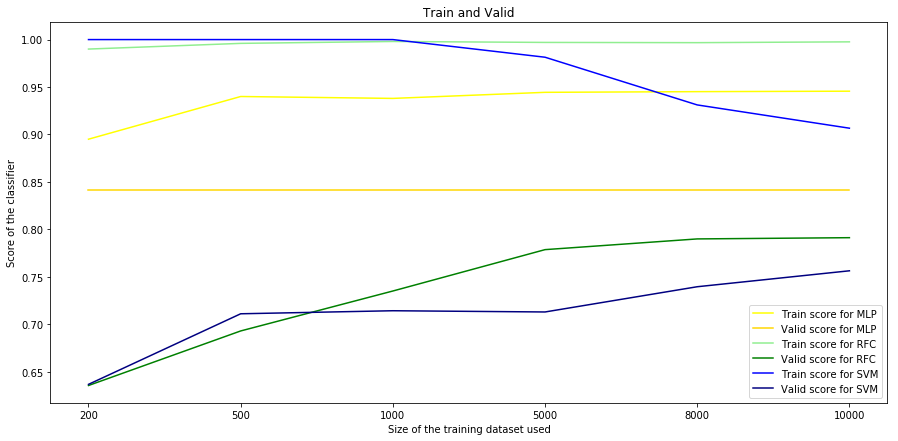

In [46]:
plt.figure(figsize = (15, 7))    

plt.plot(x_values, scores_train[:, 0], color = 'yellow')
plt.plot(x_values, scores_valid[:, 0], color = 'gold')
plt.plot(x_values, scores_train[:, 1], color = 'lightgreen')
plt.plot(x_values, scores_valid[:, 1], color = 'green')
plt.plot(x_values, scores_train[:, 2], color = 'blue')
plt.plot(x_values, scores_valid[:, 2], color = 'navy')

plt.xticks(np.arange(len(TRAINING_SIZES)), TRAINING_SIZES)
    
plt.legend(('Train score for MLP', 'Valid score for MLP', 'Train score for RFC', 'Valid score for RFC', 'Train score for SVM', 'Valid score for SVM')) 
    
plt.xlabel('Size of the training dataset used')
plt.ylabel('Score of the classifier')
    
plt.title('Train and Valid')